# **Neuropolis-X1**
### **Building an artificial intelligence system for human brain activity prediction (EEG, fMRI) with machine learning, deep learning, and large language models**

#### Maël Donoso, Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/)
*18th March 2025*

This first extension (X1) of Neuropolis includes twelve Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

*03: Classification Models*

*04: Regression Models*

*05: Neural Networks*

*06: Convolutional Neural Networks*

*07: Recurrent Neural Networks*

*08: Transformers*

***09: Large Language Models***

*10: Large Language Model Chain-of-Thought*

*11: Large Language Model Fine-Tuning*

*12: Large Multimodal Model*

### Notebook 09

# **Large Language Models**

## **1. Region-Channel Mapping**

We define a **region-channel mapping**, associating each brain region to the EEG channel whose signal is most likely to provide relevant information regarding its fMRI activity. This ad hoc mapping is based, in particular, on electrode proximity to the brain region. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import mne
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, logging

In [2]:
# Define the raw data path. 
raw_data_path = '../../Neuropolis/ds002336-download/'

# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis-x1_preprocessed_data/'

# Define the results path. 
results_path = '../neuropolis-x1_results/'

In [3]:
# Load the features and the targets for the classification task. 
with open(preprocessed_data_path + 'dict_targets.p', 'rb') as file:
    dict_targets = pickle.load(file)
with open(preprocessed_data_path + 'classification/dict_features_classification_basis.p', 'rb') as file:
    dict_features_basis_class = pickle.load(file)
with open(preprocessed_data_path + 'classification/dict_targets_classification_basis.p', 'rb') as file:
    dict_targets_basis_class = pickle.load(file)

In [4]:
# Define the list of subjects and an example subject. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
subject = subjects[0]

# Retrieve and display the total number of scans. 
nb_scans_total = dict_targets[subject]['eegfmriNF']['Frontal Pole'].shape[0]
nb_scans_total

200

In [5]:
# Retrieve the list of all targets. 
targets = list(dict_targets[subject]['eegfmriNF'].keys())

# Display the brain region names and the number of brain regions. 
print(targets)
print(len(targets), 'brain regions')

['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate

In [6]:
# Define the bandpower names. 
bandpower_names = ['Delta (1-4 Hz)', 'Theta (4-8 Hz)', 'Alpha (8-12 Hz)', 'Sigma (12-16 Hz)', 'Beta (16-30 Hz)', 'Gamma (30-40 Hz)']

# Define the path of the header file (.vhdr) for this subject, for the eegfmriNF condition. 
vhdr_path = raw_data_path + 'derivatives/' + subject + '/eeg_pp/' + subject + '_task-eegfmriNF_eeg_pp.vhdr'

# Load the EEG data using the MNE library, keeping error messages but suppressing warnings. 
channels_data = mne.io.read_raw_brainvision(vhdr_path, misc = ['ECG'], preload = True, verbose = 'ERROR')

# Remove the ECG channel from the channel names. 
channel_names = channels_data.ch_names
channel_names.remove('ECG')

# Display the channel names and the number of channels. 
print(channel_names)
print(len(channel_names), 'channels')

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
63 channels


In [7]:
# Define for each brain region the EEG channel whose signal is most likely to provide relevant information regarding fMRI activity. 
region_channel_mapping = {
    'Frontal Pole': 'Fpz',
    'Insular Cortex': 'T7',
    'Superior Frontal Gyrus': 'Fz',
    'Middle Frontal Gyrus': 'F3',
    'Inferior Frontal Gyrus, pars triangularis': 'F7',
    'Inferior Frontal Gyrus, pars opercularis': 'F7',
    'Precentral Gyrus': 'C3',
    'Temporal Pole': 'FT9',
    'Superior Temporal Gyrus, anterior division': 'FT7',
    'Superior Temporal Gyrus, posterior division': 'T7',
    'Middle Temporal Gyrus, anterior division': 'T7',
    'Middle Temporal Gyrus, posterior division': 'T7',
    'Middle Temporal Gyrus, temporooccipital part': 'P7',
    'Inferior Temporal Gyrus, anterior division': 'T7',
    'Inferior Temporal Gyrus, posterior division': 'P7',
    'Inferior Temporal Gyrus, temporooccipital part': 'PO7',
    'Postcentral Gyrus': 'C3',
    'Superior Parietal Lobule': 'Pz',
    'Supramarginal Gyrus, anterior division': 'CP3',
    'Supramarginal Gyrus, posterior division': 'P3',
    'Angular Gyrus': 'P3',
    'Lateral Occipital Cortex, superior division': 'PO3',
    'Lateral Occipital Cortex, inferior division': 'O1',
    'Intracalcarine Cortex': 'Oz',
    'Frontal Medial Cortex': 'Fz',
    'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)': 'Cz',
    'Subcallosal Cortex': 'Fpz',
    'Paracingulate Gyrus': 'Fz',
    'Cingulate Gyrus, anterior division': 'Fz',
    'Cingulate Gyrus, posterior division': 'Pz',
    'Precuneous Cortex': 'Pz',
    'Cuneal Cortex': 'Oz',
    'Frontal Orbital Cortex': 'Fp1',
    'Parahippocampal Gyrus, anterior division': 'FT9',
    'Parahippocampal Gyrus, posterior division': 'TP9',
    'Lingual Gyrus': 'Oz',
    'Temporal Fusiform Cortex, anterior division': 'FT9',
    'Temporal Fusiform Cortex, posterior division': 'TP9',
    'Temporal Occipital Fusiform Cortex': 'PO7',
    'Occipital Fusiform Gyrus': 'PO7',
    'Frontal Opercular Cortex': 'FC5',
    'Central Opercular Cortex': 'C3',
    'Parietal Opercular Cortex': 'CP3',
    'Planum Polare': 'FT7',
    "Heschl's Gyrus (includes H1 and H2)": 'T7',
    'Planum Temporale': 'TP7',
    'Supracalcarine Cortex': 'Oz',
    'Occipital Pole': 'Oz'
}

## **2. Gemma**

We use the **Gemma-2-2B-IT large language model**, and select its hyperparameters in order to ensure a relative variety of responses. We define a prompt where we provide a sequence of EEG bandpower values, and ask the model to predict the corresponding fMRI activity. We run the large language model on the eegfmriNF condition of all subjects, for a selection of brain regions spanning both a substantial fraction of the brain and a variety of cognitive functions. The large language model predicts the evolution of the fMRI signal with an accuracy slightly higher than the baseline. 

In [8]:
# Define the LLM to use. 
model_name = 'google/gemma-2-2b-it'

# Load the tokenizer and the model. 
tokenizer_gemma = AutoTokenizer.from_pretrained(model_name)
model_gemma = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype = torch.float16, device_map = 'auto')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# Define a function to create a LLM prompt with a sequence of bandpower values. 
def prompt_llm(X, fmri_scan_index, sequence_length, selected_bandpowers, selected_eeg_channel, selected_brain_region):

    # Retrieve the sequence of features. 
    X_sequence = X[(fmri_scan_index - sequence_length):fmri_scan_index, :]

    # Create the prompt. 
    bandpowers_results = ', '.join(
        f"{bandpower_names[bandpower_index]}: {X_sequence[:, bandpower_index]}" for bandpower_index in selected_bandpowers
    )
    prompt = (
        f"A human subject participated in a neuroscience experiment where EEG data and fMRI data were recorded simultaneously. "
        f"The EEG band powers were measured every two seconds at electrode {selected_eeg_channel}, "
        f"with the following results: {bandpowers_results}. "
        f"The fMRI BOLD signal was measured in the {selected_brain_region} during the last two seconds. "
        f"Given the EEG data, is the fMRI signal in this brain region likely increasing or decreasing during these last two seconds? "
        f"Base your answer on your general knowledge in neuroscience, EEG research, and fMRI research. "
        f"Since this is a time series, you might need to take into account the hemodynamic response function (HRF), "
        f"and the fact that after an event, the fMRI response is delayed compared to the EEG response. "
        f"Please answer with only one word: Increasing or Decreasing. Just give your best prediction, without any explanation."
    )

    return prompt

In [10]:
# Define a function to run a LLM. 
def run_llm(prompt, tokenizer, model):

    # Run the LLM. 
    inputs = tokenizer(prompt, return_tensors = 'pt').to(model.device)
    output = model.generate(**inputs, 
                            max_new_tokens = 20, 
                            temperature = 1.2, 
                            top_p = 0.9, 
                            top_k = 50, 
                            do_sample = True, 
                            repetition_penalty = 1)

    # Decode the generated text, remove the original prompt, and return the answer. 
    generated_text = tokenizer.decode(output[0], skip_special_tokens = True)
    answer_only = generated_text[len(prompt):].strip()
    
    return answer_only

In [11]:
# Define a function to run a LLM multiple times. 
def run_llm_series(X, Y, fmri_scans, sequence_length, selected_bandpowers, selected_eeg_channel, selected_brain_region, tokenizer, model):

    # Create the NumPy arrays to store the true values and predictions.     
    Y_true = np.zeros(len(fmri_scans))
    Y_pred = np.zeros(len(fmri_scans))
    answers = []
    counter = 0

    # Iterate through all selected fMRI scans. 
    for fmri_scan_index in fmri_scans:

        # Create the LLM prompt. 
        prompt = prompt_llm(X, 
                            fmri_scan_index = fmri_scan_index, 
                            sequence_length = sequence_length, 
                            selected_bandpowers = selected_bandpowers, 
                            selected_eeg_channel = selected_eeg_channel, 
                            selected_brain_region = selected_brain_region)
        
        # Run the LLM and store the result. 
        answer_only = run_llm(prompt, tokenizer, model)
        answers.append(answer_only) # For debugging purposes. 

        # Analyze the answer. 
        increase_detected = 'increas' in answer_only.lower()
        decrease_detected = 'decreas' in answer_only.lower()
        if increase_detected and not decrease_detected:
            Y_pred[counter] = 1
        elif decrease_detected and not increase_detected:
            Y_pred[counter] = 0
        else:
            Y_pred[counter] = -1

        # Store the true value.
        Y_true[counter] = Y[fmri_scan_index]

        # Increment. 
        counter += 1

    return Y_true, Y_pred

In [12]:
# Select a subject and a condition. 
subject = 'sub-xp101'
condition = 'eegfmriNF'

# Select a fMRI brain region and retrieve its corresponding EEG channel. 
selected_brain_region = 'Frontal Pole'
selected_brain_region_index = list(targets).index(selected_brain_region)
selected_eeg_channel = region_channel_mapping[selected_brain_region]
selected_eeg_channel_index = channel_names.index(selected_eeg_channel)

# Display the fMRI brain region and its corresponding EEG channel. 
print('Brain region:', selected_brain_region)
print('Brain region index:', int(selected_brain_region_index))
print('EEG channel:', selected_eeg_channel)
print('EEG channel index:', int(selected_eeg_channel_index))

Brain region: Frontal Pole
Brain region index: 1
EEG channel: Fpz
EEG channel index: 61


In [13]:
# Retrieve the features for the selected subject, condition, and EEG channel. 
X = dict_features_basis_class[subject][condition][:, (selected_eeg_channel_index * len(bandpower_names)):(selected_eeg_channel_index * len(bandpower_names)) + len(bandpower_names)]

# Retrieve the targets for the selected subject, condition, and fMRI brain region. 
Y = dict_targets_basis_class[subject][condition][:, selected_brain_region_index]

# Select the sequence length and the bandpowers. 
sequence_length = 5
selected_bandpowers = [0, 1, 2, 4]

# Create the LLM prompt. 
prompt = prompt_llm(X, 
                    fmri_scan_index = 5, 
                    sequence_length = sequence_length, 
                    selected_bandpowers = selected_bandpowers, 
                    selected_eeg_channel = selected_eeg_channel, 
                    selected_brain_region = selected_brain_region)
prompt

'A human subject participated in a neuroscience experiment where EEG data and fMRI data were recorded simultaneously. The EEG band powers were measured every two seconds at electrode Fpz, with the following results: Delta (1-4 Hz): [-0.22278232  0.64400346  1.11835758 -1.24585523 -0.13343407], Theta (4-8 Hz): [ 0.3256324  -0.68492586 -0.96076972  0.99095653 -0.37529182], Alpha (8-12 Hz): [-0.40537466 -0.04844749 -0.69866725  0.40412502  1.11390381], Beta (16-30 Hz): [ 0.55265258 -0.03498027 -0.91193884  1.92475433  1.92719948]. The fMRI BOLD signal was measured in the Frontal Pole during the last two seconds. Given the EEG data, is the fMRI signal in this brain region likely increasing or decreasing during these last two seconds? Base your answer on your general knowledge in neuroscience, EEG research, and fMRI research. Since this is a time series, you might need to take into account the hemodynamic response function (HRF), and the fact that after an event, the fMRI response is delaye

In [14]:
# Run the LLM once, and display the result. 
answer_only = run_llm(prompt, tokenizer_gemma, model_gemma)
answer_only

'Decreasing'

In [15]:
# Run the LLM multiple times. 
fmri_scans = range(5, (nb_scans_total - 1), 10)
Y_true, Y_pred = run_llm_series(X, Y, fmri_scans, sequence_length, selected_bandpowers, selected_eeg_channel, selected_brain_region, tokenizer_gemma, model_gemma)

# Compute the average accuracy. 
accuracy_array = Y_pred[Y_pred != -1] == Y_true[Y_pred != -1]
accuracy_sequence = np.sum(accuracy_array) / accuracy_array.shape[0]
accuracy_sequence

0.3888888888888889

In [16]:
# Select a condition and a list of brain regions. 
condition = 'eegfmriNF'
brain_regions = ['Frontal Pole', # High-order cognitive functions, but sometimes noisy EEG signal. 
                 'Insular Cortex', # Integrative functions. 
                 'Inferior Frontal Gyrus, pars triangularis', # Language and executive functions. 
                 'Precentral Gyrus', # Primary motor cortex. 
                 'Superior Temporal Gyrus, posterior division', # Auditory functions. 
                 'Superior Parietal Lobule', # Attention functions. 
                 'Angular Gyrus', # Default-mode network. 
                 'Occipital Pole'] # Primary visual cortex. 

# Define a Pandas DataFrame to store the accuracy. 
accuracy_summary_gemma = pd.DataFrame(columns = brain_regions)

# Iterate through all brain regions. 
for selected_brain_region in brain_regions:

    # Display the current brain region. 
    print(selected_brain_region)

    # Retrieve the EEG channel corresponding to the brain region. 
    selected_brain_region_index = list(targets).index(selected_brain_region)
    selected_eeg_channel = region_channel_mapping[selected_brain_region]
    selected_eeg_channel_index = channel_names.index(selected_eeg_channel)

    # Iterate through all subjects. 
    for subject in subjects:
        
        # Retrieve the features for the selected subject, condition, and EEG channel. 
        X = dict_features_basis_class[subject][condition][:, (selected_eeg_channel_index * len(bandpower_names)):(selected_eeg_channel_index * len(bandpower_names)) + len(bandpower_names)]

        # Retrieve the targets for the selected subject, condition, and fMRI brain region. 
        Y = dict_targets_basis_class[subject][condition][:, selected_brain_region_index]

        # Run the LLM multiple times. 
        fmri_scans = range(5, (nb_scans_total - 1), 10) # Extensive search. 
        #fmri_scans = range(5, (nb_scans_total - 1), 100) # Quick search for debugging. 
        Y_true, Y_pred = run_llm_series(X, Y, fmri_scans, sequence_length, selected_bandpowers, selected_eeg_channel, selected_brain_region, tokenizer_gemma, model_gemma)

        # Compute and store the average accuracy. 
        accuracy_array = Y_pred[Y_pred != -1] == Y_true[Y_pred != -1]
        accuracy_sequence = np.sum(accuracy_array) / accuracy_array.shape[0]
        accuracy_summary_gemma.loc[subject, selected_brain_region] = accuracy_sequence

        # Display the number of ambiguous predictions. 
        print(subject + ': ' + str(np.sum(Y_pred == -1)), 'ambiguous prediction(s) out of', len(Y_pred), '-', str(np.sum(Y_pred == -1) / len(Y_pred) * 100), '%')

Frontal Pole
sub-xp101: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp102: 0 ambiguous prediction(s) out of 20 - 0.0 %
sub-xp103: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp104: 0 ambiguous prediction(s) out of 20 - 0.0 %
sub-xp105: 3 ambiguous prediction(s) out of 20 - 15.0 %
sub-xp106: 0 ambiguous prediction(s) out of 20 - 0.0 %
sub-xp107: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp108: 3 ambiguous prediction(s) out of 20 - 15.0 %
sub-xp109: 0 ambiguous prediction(s) out of 20 - 0.0 %
sub-xp110: 1 ambiguous prediction(s) out of 20 - 5.0 %
Insular Cortex
sub-xp101: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp102: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp103: 2 ambiguous prediction(s) out of 20 - 10.0 %
sub-xp104: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp105: 2 ambiguous prediction(s) out of 20 - 10.0 %
sub-xp106: 0 ambiguous prediction(s) out of 20 - 0.0 %
sub-xp107: 2 ambiguous prediction(s) out of 20 - 10.0 %
sub-xp108: 2 ambiguous predictio

In [17]:
# Display the accuracies per subject and brain region. 
accuracy_summary_gemma

,Frontal Pole,Insular Cortex,"Inferior Frontal Gyrus, pars triangularis",Precentral Gyrus,"Superior Temporal Gyrus, posterior division",Superior Parietal Lobule,Angular Gyrus,Occipital Pole
sub-xp101,0.368421,0.526316,0.5,0.5,0.6,0.473684,0.6,0.4
sub-xp102,0.65,0.315789,0.4,0.789474,0.55,0.65,0.75,0.75
sub-xp103,0.526316,0.444444,0.526316,0.55,0.736842,0.45,0.5,0.55
sub-xp104,0.5,0.789474,0.631579,0.473684,0.35,0.611111,0.45,0.65
sub-xp105,0.470588,0.333333,0.473684,0.5,0.55,0.5,0.75,0.666667
sub-xp106,0.4,0.45,0.25,0.55,0.315789,0.45,0.444444,0.4
sub-xp107,0.526316,0.666667,0.526316,0.5625,0.5,0.277778,0.7,0.6
sub-xp108,0.529412,0.5,0.55,0.368421,0.55,0.736842,0.578947,0.473684
sub-xp109,0.5,0.75,0.35,0.526316,0.65,0.631579,0.45,0.777778
sub-xp110,0.631579,0.368421,0.7,0.4,0.5,0.631579,0.421053,0.5


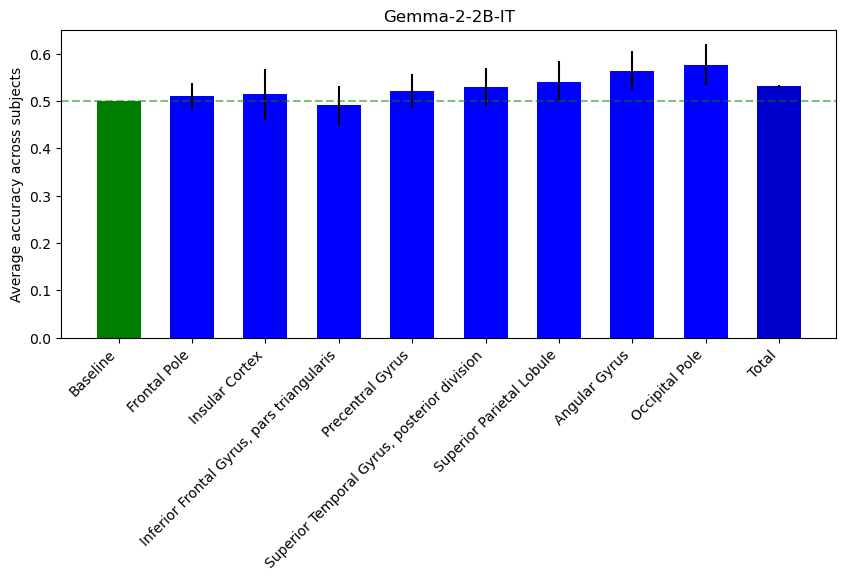

In [18]:
# Retrieve the average accuracy across subjects, and the standard error of the accuracy across subjects. 
accuracy_mean = list(accuracy_summary_gemma.mean().values)
accuracy_mean.insert(0, 0.5) # Insert a baseline average of 0.5. 
accuracy_se = list(accuracy_summary_gemma.std().values / np.sqrt(len(subjects)))
accuracy_se.insert(0, 0) # Insert a baseline standard error of 0. 

# Append the total average accuracy and its standard error. 
nb_brain_regions = accuracy_summary_gemma.shape[1]
accuracy_mean.append(np.mean(accuracy_mean[1:]))
accuracy_se.append(np.std(accuracy_mean[1:]) / (np.sqrt(len(subjects) * nb_brain_regions)))

# Create the labels. 
labels = brain_regions.copy()
labels.insert(0, 'Baseline')
labels.append('Total')

# Display the average accuracy and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 4))
axes.bar(range(nb_brain_regions + 2), accuracy_mean, width = 0.6, color = ['green', *['blue'] * nb_brain_regions, 'mediumblue'])
axes.errorbar(range(nb_brain_regions + 2), accuracy_mean, yerr = accuracy_se, fmt = 'None', color = 'black')
axes.axhline(accuracy_mean[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(nb_brain_regions + 2), labels = labels)
axes.set_xticklabels(labels, rotation = 45, ha = 'right')
axes.set_ylabel('Average accuracy across subjects')
axes.set_title('Gemma-2-2B-IT');

## **3. Llama**

We use the **Llama-3.2-3B-Instruct large language model**, selecting the same hyperparameters as for the Gemma-2-2B-IT model, and defining the prompt in the same way. We run the large language model on the eegfmriNF condition of all subjects, for the same selection of brain regions. The large language model stays below the baseline, and does not predict accurately the evolution of the fMRI signal. 

In [19]:
# Define the LLM to use. 
model_name = 'meta-llama/Llama-3.2-3B-Instruct'

# Load the tokenizer and the model. 
tokenizer_llama = AutoTokenizer.from_pretrained(model_name)
model_llama = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype = torch.float16, device_map = 'auto')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
# Select a subject and a condition. 
subject = 'sub-xp101'
condition = 'eegfmriNF'

# Select a fMRI brain region and retrieve its corresponding EEG channel. 
selected_brain_region = 'Frontal Pole'
selected_brain_region_index = list(targets).index(selected_brain_region)
selected_eeg_channel = region_channel_mapping[selected_brain_region]
selected_eeg_channel_index = channel_names.index(selected_eeg_channel)

# Display the fMRI brain region and its corresponding EEG channel. 
print('Brain region:', selected_brain_region)
print('Brain region index:', int(selected_brain_region_index))
print('EEG channel:', selected_eeg_channel)
print('EEG channel index:', int(selected_eeg_channel_index))

Brain region: Frontal Pole
Brain region index: 1
EEG channel: Fpz
EEG channel index: 61


In [21]:
# Retrieve the features for the selected subject, condition, and EEG channel. 
X = dict_features_basis_class[subject][condition][:, (selected_eeg_channel_index * len(bandpower_names)):(selected_eeg_channel_index * len(bandpower_names)) + len(bandpower_names)]

# Retrieve the targets for the selected subject, condition, and fMRI brain region. 
Y = dict_targets_basis_class[subject][condition][:, selected_brain_region_index]

# Select the sequence length and the bandpowers. 
sequence_length = 5
selected_bandpowers = [0, 1, 2, 4]

# Create the LLM prompt. 
prompt = prompt_llm(X, 
                    fmri_scan_index = 5, 
                    sequence_length = sequence_length, 
                    selected_bandpowers = selected_bandpowers, 
                    selected_eeg_channel = selected_eeg_channel, 
                    selected_brain_region = selected_brain_region)
prompt

'A human subject participated in a neuroscience experiment where EEG data and fMRI data were recorded simultaneously. The EEG band powers were measured every two seconds at electrode Fpz, with the following results: Delta (1-4 Hz): [-0.22278232  0.64400346  1.11835758 -1.24585523 -0.13343407], Theta (4-8 Hz): [ 0.3256324  -0.68492586 -0.96076972  0.99095653 -0.37529182], Alpha (8-12 Hz): [-0.40537466 -0.04844749 -0.69866725  0.40412502  1.11390381], Beta (16-30 Hz): [ 0.55265258 -0.03498027 -0.91193884  1.92475433  1.92719948]. The fMRI BOLD signal was measured in the Frontal Pole during the last two seconds. Given the EEG data, is the fMRI signal in this brain region likely increasing or decreasing during these last two seconds? Base your answer on your general knowledge in neuroscience, EEG research, and fMRI research. Since this is a time series, you might need to take into account the hemodynamic response function (HRF), and the fact that after an event, the fMRI response is delaye

In [22]:
# Suppress the transformers library logging. 
logging.set_verbosity_error()

# Run the LLM once, and display the result. 
answer_only = run_llm(prompt, tokenizer_llama, model_llama)
answer_only

'Decreasing.'

In [23]:
# Run the LLM multiple times. 
fmri_scans = range(5, (nb_scans_total - 1), 10)
Y_true, Y_pred = run_llm_series(X, Y, fmri_scans, sequence_length, selected_bandpowers, selected_eeg_channel, selected_brain_region, tokenizer_llama, model_llama)

# Compute the average accuracy. 
accuracy_array = Y_pred[Y_pred != -1] == Y_true[Y_pred != -1]
accuracy_sequence = np.sum(accuracy_array) / accuracy_array.shape[0]
accuracy_sequence

0.6875

In [24]:
# Select a condition and a list of brain regions. 
condition = 'eegfmriNF'
brain_regions = ['Frontal Pole', # High-order cognitive functions, but sometimes noisy EEG signal. 
                 'Insular Cortex', # Integrative functions. 
                 'Inferior Frontal Gyrus, pars triangularis', # Language and executive functions. 
                 'Precentral Gyrus', # Primary motor cortex. 
                 'Superior Temporal Gyrus, posterior division', # Auditory functions. 
                 'Superior Parietal Lobule', # Attention functions. 
                 'Angular Gyrus', # Default-mode network. 
                 'Occipital Pole'] # Primary visual cortex. 

# Define a Pandas DataFrame to store the accuracy. 
accuracy_summary_llama = pd.DataFrame(columns = brain_regions)

# Iterate through all brain regions. 
for selected_brain_region in brain_regions:

    # Display the current brain region. 
    print(selected_brain_region)

    # Retrieve the EEG channel corresponding to the brain region. 
    selected_brain_region_index = list(targets).index(selected_brain_region)
    selected_eeg_channel = region_channel_mapping[selected_brain_region]
    selected_eeg_channel_index = channel_names.index(selected_eeg_channel)

    # Iterate through all subjects. 
    for subject in subjects:
        
        # Retrieve the features for the selected subject, condition, and EEG channel. 
        X = dict_features_basis_class[subject][condition][:, (selected_eeg_channel_index * len(bandpower_names)):(selected_eeg_channel_index * len(bandpower_names)) + len(bandpower_names)]

        # Retrieve the targets for the selected subject, condition, and fMRI brain region. 
        Y = dict_targets_basis_class[subject][condition][:, selected_brain_region_index]

        # Run the LLM multiple times. 
        fmri_scans = range(5, (nb_scans_total - 1), 10) # Extensive search. 
        #fmri_scans = range(5, (nb_scans_total - 1), 100) # Quick search for debugging. 
        Y_true, Y_pred = run_llm_series(X, Y, fmri_scans, sequence_length, selected_bandpowers, selected_eeg_channel, selected_brain_region, tokenizer_llama, model_llama)

        # Compute and store the average accuracy. 
        accuracy_array = Y_pred[Y_pred != -1] == Y_true[Y_pred != -1]
        accuracy_sequence = np.sum(accuracy_array) / accuracy_array.shape[0]
        accuracy_summary_llama.loc[subject, selected_brain_region] = accuracy_sequence

        # Display the number of ambiguous predictions. 
        print(subject + ': ' + str(np.sum(Y_pred == -1)), 'ambiguous prediction(s) out of', len(Y_pred), '-', str(np.sum(Y_pred == -1) / len(Y_pred) * 100), '%')

Frontal Pole
sub-xp101: 2 ambiguous prediction(s) out of 20 - 10.0 %
sub-xp102: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp103: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp104: 3 ambiguous prediction(s) out of 20 - 15.0 %
sub-xp105: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp106: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp107: 6 ambiguous prediction(s) out of 20 - 30.0 %
sub-xp108: 2 ambiguous prediction(s) out of 20 - 10.0 %
sub-xp109: 3 ambiguous prediction(s) out of 20 - 15.0 %
sub-xp110: 1 ambiguous prediction(s) out of 20 - 5.0 %
Insular Cortex
sub-xp101: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp102: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp103: 5 ambiguous prediction(s) out of 20 - 25.0 %
sub-xp104: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp105: 3 ambiguous prediction(s) out of 20 - 15.0 %
sub-xp106: 2 ambiguous prediction(s) out of 20 - 10.0 %
sub-xp107: 3 ambiguous prediction(s) out of 20 - 15.0 %
sub-xp108: 1 ambiguous predi

In [25]:
# Display the accuracies per subject and brain region. 
accuracy_summary_llama

,Frontal Pole,Insular Cortex,"Inferior Frontal Gyrus, pars triangularis",Precentral Gyrus,"Superior Temporal Gyrus, posterior division",Superior Parietal Lobule,Angular Gyrus,Occipital Pole
sub-xp101,0.444444,0.473684,0.4,0.55,0.647059,0.529412,0.473684,0.5
sub-xp102,0.578947,0.578947,0.684211,0.789474,0.3,0.444444,0.375,0.55
sub-xp103,0.473684,0.266667,0.666667,0.421053,0.277778,0.631579,0.5625,0.315789
sub-xp104,0.470588,0.315789,0.5,0.444444,0.666667,0.736842,0.388889,0.529412
sub-xp105,0.526316,0.411765,0.473684,0.5,0.470588,0.388889,0.4,0.526316
sub-xp106,0.368421,0.388889,0.421053,0.578947,0.4,0.55,0.473684,0.625
sub-xp107,0.714286,0.352941,0.411765,0.526316,0.588235,0.578947,0.473684,0.555556
sub-xp108,0.444444,0.315789,0.588235,0.333333,0.4,0.529412,0.55,0.631579
sub-xp109,0.470588,0.578947,0.55,0.4,0.611111,0.3125,0.421053,0.631579
sub-xp110,0.368421,0.473684,0.352941,0.35,0.5625,0.473684,0.666667,0.578947


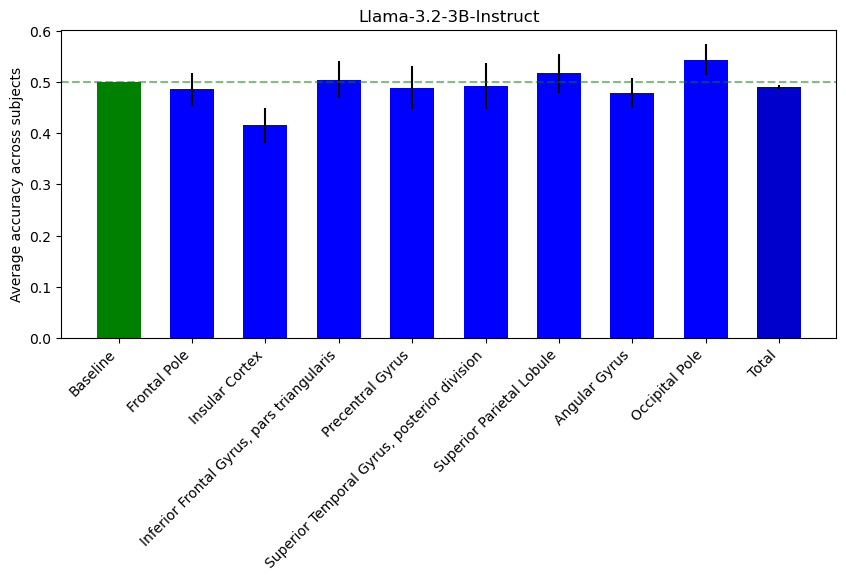

In [26]:
# Retrieve the average accuracy across subjects, and the standard error of the accuracy across subjects. 
accuracy_mean = list(accuracy_summary_llama.mean().values)
accuracy_mean.insert(0, 0.5) # Insert a baseline average of 0.5. 
accuracy_se = list(accuracy_summary_llama.std().values / np.sqrt(len(subjects)))
accuracy_se.insert(0, 0) # Insert a baseline standard error of 0. 

# Append the total average accuracy and its standard error. 
nb_brain_regions = accuracy_summary_llama.shape[1]
accuracy_mean.append(np.mean(accuracy_mean[1:]))
accuracy_se.append(np.std(accuracy_mean[1:]) / (np.sqrt(len(subjects) * nb_brain_regions)))

# Create the labels. 
labels = brain_regions.copy()
labels.insert(0, 'Baseline')
labels.append('Total')

# Display the average accuracy and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 4))
axes.bar(range(nb_brain_regions + 2), accuracy_mean, width = 0.6, color = ['green', *['blue'] * nb_brain_regions, 'mediumblue'])
axes.errorbar(range(nb_brain_regions + 2), accuracy_mean, yerr = accuracy_se, fmt = 'None', color = 'black')
axes.axhline(accuracy_mean[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(nb_brain_regions + 2), labels = labels)
axes.set_xticklabels(labels, rotation = 45, ha = 'right')
axes.set_ylabel('Average accuracy across subjects')
axes.set_title('Llama-3.2-3B-Instruct');

## **4. Results**

We save the results in the appropriate directory. 

In [27]:
# Save the results and the region-channel mapping into Pickle files. 
with open(results_path + 'classification/accuracy_summary_gemma.p', 'wb') as file:
    pickle.dump(accuracy_summary_gemma, file)
with open(results_path + 'classification/accuracy_summary_llama.p', 'wb') as file:
    pickle.dump(accuracy_summary_llama, file)
with open(results_path + 'region_channel_mapping.p', 'wb') as file:
    pickle.dump(region_channel_mapping, file)